## Setup

必要なライブラリをインポートして、初期化を行います。

Import the required libraries and initialize them:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped,PoseStamped
import tf2_ros
import sys
from sklearn.decomposition import PCA
from utils import *
import cv2
import os
import math as m

from utils_takeshi import *
rgbd = RGBD()
scene = moveit_commander.PlanningSceneInterface()

In [2]:
%%script bash --bg
rviz -d data/task1.rviz > /dev/null 2>&1

Starting job # 0 in a separate thread.


In [3]:

rospy.init_node("recognition")
tf_static_broadcaster = tf2_ros.StaticTransformBroadcaster()

In [4]:
def add_transform(child, trans, rot, parent="map"):
    static_transformStamped = TransformStamped()
    static_transformStamped.header.stamp = rospy.Time.now()
    static_transformStamped.header.frame_id = parent
    static_transformStamped.child_frame_id = child
    static_transformStamped.transform.translation.x = trans[0]
    static_transformStamped.transform.translation.y = trans[1]
    static_transformStamped.transform.translation.z = trans[2]
    static_transformStamped.transform.rotation.x = rot[0]    
    static_transformStamped.transform.rotation.y = rot[1]    
    static_transformStamped.transform.rotation.z = rot[2]    
    static_transformStamped.transform.rotation.w = rot[3]    
    tf_static_broadcaster.sendTransform(static_transformStamped)

def add_object(name, size, pose, orientation):
    p = PoseStamped()
    p.header.frame_id = "map"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.y = orientation[1] * np.pi
    p.pose.orientation.z = orientation[2] * np.pi
    p.pose.orientation.w = orientation[3] * np.pi

    scene.add_box(name, p, size)


def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4],  [2.5, 4.85, 0.78],  [0.5,0,0,0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.85, 0.49], [0.5,0,0, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.85, 0.18], [0.5,0,0, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5,0,0, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5],[0.5,0,0, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5,0,0 ,0.5])    
    add_object("table_big", [1.5, 0.13, 0.5], [0.95, 1.9, 0.34],  [0.5,0,0, 0.5])
    add_object("table_big_legs1",[.01,.6,.2], [1.55,1.8,0.1],       [0.5,0,0, 0.5])
    add_object("table_big_legs2",[.01,.6,.2], [0.45,1.8,0.1],       [0.5,0,0 ,0.5])
    add_object("table_small", [0.9, 0.02, 0.4], [-0.2, 1.85, 0.61],  [0.5,0,0 ,0.5])
    add_object("table_small_legs1",[.01,.6,.2], [-0.3,1.75,0.3],      [0.5,0,0, 0.5])
    add_object("table_small_legs2",[.01,.6,.2], [0.1,1.75,0.3], [0.5,0,0 ,0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5,0,0, 0.5])
    add_object("containers", [0.3, 0.3, 0.3], [1.4, -0.65, 0.4], [0.5,0,0, 0.5])
    add_object("drawers", [1, 1, 1], [0, -0.65, 0.5], [0.5,0,0, 0.5])
    add_object("big_wall" , [6.0, 0.2, 0.2], [3.2,  2.0, 0.0],  [0,0.0,0.5 ,0.5])
    add_object("mid_wall" , [4.0, 0.2, 0.2], [0.1,  2.1, 0.0],  [0,0.0,0.0 ,1/np.pi])
    add_object("door_wall" , [5.0, 0.2, 0.2], [-0.8, 2.8, 0.0],  [0,0.0,0.5 ,0.5     ])
    add_object("close_wall", [4.0, 0.2, 0.2], [1.1, -0.5, 0.0],  [0,0.0,0.0 ,1/np.pi])
    add_object("far_wall",   [4.0, 0.2, 0.2], [1.1, 5.0, 0.0],  [0,0.0,0.0 ,1/np.pi])
    
    add_transform("Tray_B", [1.97, -0.59, 0.4], [0, 0, 0, 1])
    add_transform("Tray_A", [1.665, -0.59, 0.4], [0, 0, 0, 1])

    static_transformStamped=TransformStamped()

      ##FIXING TF TO MAP ( ODOM REALLY)    
    static_transformStamped.header.stamp = rospy.Time.now()
    static_transformStamped.header.frame_id = "map"
    static_transformStamped.child_frame_id = "Drawer_low" 
    static_transformStamped.transform.translation.x = 0.14
    static_transformStamped.transform.translation.y = -0.344
    static_transformStamped.transform.translation.z = 0.27
    static_transformStamped.transform.rotation.x = 0    
    static_transformStamped.transform.rotation.y = 0    
    static_transformStamped.transform.rotation.z = 0    
    static_transformStamped.transform.rotation.w = 1    

    tf_static_broadcaster.sendTransform(static_transformStamped)
    ##FIXING TF TO MAP ( ODOM REALLY)    
    static_transformStamped.header.stamp = rospy.Time.now()
    static_transformStamped.header.frame_id = "map"
    static_transformStamped.child_frame_id = "Box1" 
    static_transformStamped.transform.translation.x = 2.4
    static_transformStamped.transform.translation.y = -0.5
    static_transformStamped.transform.translation.z = .5
    static_transformStamped.transform.rotation.x = 0    
    static_transformStamped.transform.rotation.y = 0    
    static_transformStamped.transform.rotation.z = 0    
    static_transformStamped.transform.rotation.w = 1    

    tf_static_broadcaster.sendTransform(static_transformStamped)  
    static_transformStamped.header.stamp = rospy.Time.now()
    static_transformStamped.header.frame_id = "map"
    static_transformStamped.child_frame_id = "Drawer_left" 
    static_transformStamped.transform.translation.x = .45
    static_transformStamped.transform.translation.y = -0.33
    static_transformStamped.transform.translation.z = .28
    static_transformStamped.transform.rotation.x = 0    
    static_transformStamped.transform.rotation.y = 0    
    static_transformStamped.transform.rotation.z = 0    
    static_transformStamped.transform.rotation.w = 1    

    return True

In [5]:
publish_scene()
#scene.remove_world_object()

True

In [6]:

def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
            
    cents=np.asarray(cents)
    plt.imshow(im4)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points))



def static_tf_publish(cents, quaternions=[]):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        print quats
    else:
        quats=np.asarray(quaternions)
        print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Closest_Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            static_transformStamped.child_frame_id = "static"+str(i)
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


            tf_static_broadcaster.sendTransform(static_transformStamped)
    return True




In [7]:
def lineup_table():
    
    cv2_img=rgbd.get_image()
    img=cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    img=cv2.Canny(img,80,200)
    lines = cv2.HoughLines(img,1,np.pi/180,150)
    first=True
    if len(lines) ==0:
        return False
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            size=12
            if first:
                size=52
                first=False

            img=cv2.line(img,(x1,y1),(x2,y2),(255,255,255),size)

    #
    plt.imshow(img)
    wb=whole_body.get_current_joint_values()
    wb[2]+=-(lines[0,0,1]-.5*np.pi)
    if (np.isclose(lines[0,0,1], [1.57], atol=0.3)):
        succ=whole_body.go(wb)
    
    lines=np.asarray(lines)
    l=len(lines)
    lines=lines.ravel().reshape(l,2)
    table_limit_px=[]
    for line in lines :
        if (np.isclose(line[1], [1.57], atol=0.1)):
            table_limit_px.append(line[0])
    table_region=np.asarray([np.min(table_limit_px), np.max(table_limit_px)])
    print (table_region)
    
    return table_region 


In [8]:
wb_pre_table2_above=[1.084975040241123,
 -0.04307911400795569,
 1.6411492988890584,
 0.6298913727372194,
 -1.675184695826223,
 -0.027761353326655414,
 -1.5948988328043532,
 0.22356862963362012,
 0.0]
grasp_above_quat=[0.9187459 , 0.39460334, 0.00316647, 0.01357017]
grasp_table_quat=[0.26902404, -0.49059563,  0.29007591,  0.77640065]
#[0.8304410115010846,  0.04420647325614396,  -0.07858377919769033,  -0.5497618609782944]
#[-0.66287263,  0.15990841, -0.71777268, -0.14082457]


In [9]:
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()
import moveit_commander
import moveit_msgs.msg
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-10.0, -10.0, 10.0, 10.0])

In [10]:
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion
from actionlib_msgs.msg import GoalStatus

In [11]:
tries=0

<a id='start'>  Start</a>

In [12]:
### TAKE ROBOT TO TABLE WITH OBJECTS ( IDEALLY 45degs)
kl_table2
tries

0

In [13]:
publish_scene()
tries+=1
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()
goal_x , goal_y, goal_yaw = kl_table2
succ = move_base_goal(goal_x-.2, goal_y-.1 , goal_yaw+90)      

head.set_named_target('neutral')
head.go()

arm.set_joint_value_target(arm_grasp_table)
arm.go()
wb= whole_body.get_current_joint_values()
wb[3]+=.1
succ=whole_body.go(wb)

[109. 336.]


True

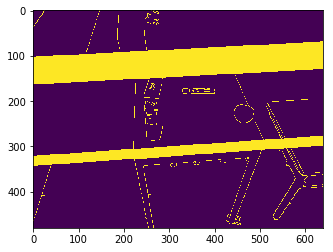

In [14]:

head_val=head.get_current_joint_values()
head_val[0]=np.deg2rad(-90)
head_val[1]=np.deg2rad(-45)
head.go(head_val)

table_region=lineup_table()

publish_scene()

In [15]:
aux=0
while abs(table_region[1]-table_region[0]) < 100 :
    aux+=1
    if aux== 5:
        break
        #return 'failed'
    table_region=lineup_table()

cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 483, 228)
[ 0.28233477 -0.02052697  0.9335711 ]
('cX,cY', 383, 175)
[ 0.10673437 -0.10888287  0.93925977]
('cX,cY', 284, 212)
[-0.05228129 -0.04195417  0.8045436 ]
[[ 0.12309258  0.53380784  0.13157028  0.82618804]
 [-0.0116926   0.02676739 -0.91782206  0.39591597]
 [ 0.71459708 -0.15008168  0.662648    0.16650564]]
centroids wrt map[[0.20231404290903793, 1.8234729075184914, 0.5589382781395371], [0.03393855020053864, 1.9062794617017655, 0.6175648871466844]]
Closest Cent 1


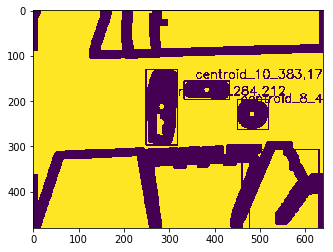

In [16]:
trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
cents, xyz = seg_pca(2000,30000,table_region[0],table_region[1])
quats=pca_xyz(xyz)
static_tf_publish(cents,quats)
trans_cents=[]
for i, cent in enumerate(cents):
    try:
        trans_map, _ = listener.lookupTransform('/map', 'static' + str(i), rospy.Time(0))
    except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
        
        continue

    trans_cents.append(trans_map)

print("centroids wrt map" + str(trans_cents))
if len(trans_cents) !=0:

    np.linalg.norm(np.asarray(trans_cents) - trans , axis = 1)
    closest_cent = np.argmin(np.linalg.norm(np.asarray(trans_cents) - trans , axis = 1))
    print("Closest Cent " + str(closest_cent))

In [17]:
for quat in quats:
    print( np.rad2deg(tf.transformations.euler_from_quaternion(quat)))

[40.69867678 58.17477831 41.41298738]
[-3.34763292e+00 -1.53660232e-02 -1.33332234e+02]
[149.50969721 -85.584191     4.59892347]


In [18]:
scene.remove_world_object()
"""[ -78.83266188   -1.31367264 -125.93617924]
[171.48644377  -1.18361917  49.53826274]
[-1.03483880e+00  8.70411565e-03 -1.33685386e+02]"""

'[ -78.83266188   -1.31367264 -125.93617924]\n[171.48644377  -1.18361917  49.53826274]\n[-1.03483880e+00  8.70411565e-03 -1.33685386e+02]'

In [19]:
a = quats[closest_cent]
np.rad2deg(tf.transformations.euler_from_quaternion(a))
grasp_above=False
if (np.abs(np.rad2deg(tf.transformations.euler_from_quaternion(a))[1]) < 1):
    grasp_above=True
    print ("grasp above recommended")
##PREGRASPS
####
move_hand(1)
if  (grasp_above!=True):#or(np.asarray(cents[closest_cent])[2]>0.9):
    print 'TABLE PREGRASP'
    grasp_above=False
    head.set_named_target('neutral')
    head.go()
    move_hand(1)
    goal_x , goal_y, goal_yaw = kl_table2
    wb= whole_body.get_current_joint_values()
    wb[0]=goal_y-0.5
    wb[1]=goal_x
    wb[2]=np.deg2rad(goal_yaw)
    wb[3:]=arm_grasp_table
    wb[3] = .6
    whole_body.go(wb)
else:
    print ' ABOVE PREGRASP'
    whole_body.go(wb_pre_table2_above)
    head.set_named_target('neutral')
    head.go()
    move_hand(1)
    wb= whole_body.get_current_joint_values()
    wb[0]=goal_y-0.5
    wb[1]=goal_x
    wb[2]=np.deg2rad(goal_yaw)
    wb[3] = .66
    wb[7] = 0

    whole_body.go(wb)
i=closest_cent
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print (trans_hand)

grasp above recommended
 ABOVE PREGRASP
[0.716597518009847, 0.1397134812950937, 0.1037220921209252]


In [20]:
grasp_above=False
if (np.abs(np.rad2deg(tf.transformations.euler_from_quaternion(a))[1]) < 1):
    grasp_above=True
    print ("grasp above recommended")

grasp above recommended


In [21]:
##PREGRASPS
####
move_hand(1)
if  (grasp_above!=True):#or(np.asarray(cents[closest_cent])[2]>0.9):
    print 'TABLE PREGRASP'
    grasp_above=False
    head.set_named_target('neutral')
    head.go()
    move_hand(1)
    goal_x , goal_y, goal_yaw = kl_table2
    wb= whole_body.get_current_joint_values()
    wb[0]=goal_y-0.5
    wb[1]=goal_x
    wb[2]=np.deg2rad(goal_yaw)
    wb[3:]=arm_grasp_table
    wb[3] = .6
    whole_body.go(wb)
else:
    print ' ABOVE PREGRASP'
    whole_body.go(wb_pre_table2_above)
    head.set_named_target('neutral')
    head.go()
    move_hand(1)
    wb= whole_body.get_current_joint_values()
    wb[0]=goal_y-0.5
    wb[1]=goal_x
    wb[2]=np.deg2rad(goal_yaw)
    wb[3] = .66
    wb[7] = 0

    whole_body.go(wb)
i=closest_cent
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print (trans_hand)

 ABOVE PREGRASP
[0.7159089110018293, 0.11637279310356016, 0.10441818852338614]


In [22]:
#scene.remove_world_object()
move_hand(1)
i=closest_cent
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand )
if grasp_above:    
    wb= whole_body.get_current_joint_values()
    wb[0]  =  np.min( (1.3, trans_hand[0]+wb[0] ))
    wb[1] += trans_hand[1] 
    wb[3] += -trans_hand[2]+.1
    

    succ=whole_body.go(wb)
    
    #move_hand(1)
else:

    wb= whole_body.get_current_joint_values()
    wb[0] += trans_hand[2] - 0.3
    wb[1] += trans_hand[1]
    wb[3] =  0.4#trans_hand[0]

    succ=whole_body.go(wb)

    
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)

print(trans_hand ,succ,wb[0])

[0.7185501278157942, 0.09812377982664497, 0.10355427885924406]
([0.11943127270696641, -0.013020958844009646, 0.17872906781069897], True, 1.3)


In [23]:
wb= whole_body.get_current_joint_values()
wb[0]

1.29826916210484

In [24]:

    
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand ,hand_euler)

([0.11849509299239491, -0.012081998394170748, 0.17892420159154265], (2.9664220888329442, -0.09050920324793599, -2.413819874322768))


In [25]:
move_hand(1)

##GRASP 
i=closest_cent
if grasp_above: 
    trans_hand,rot_hand= listener.lookupTransform('/map', 'static'+str(i),rospy.Time(0))
    hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
    print(trans_hand ,hand_euler)

    trans_hand,np.rad2deg(hand_euler)
    print(hand_euler[2])
    a=arm.get_current_joint_values()
    a[-2]=np.max((-0.5*np.pi , hand_euler[2] +.25*np.pi))
    arm.go(a)
    print (a)
    a=arm.get_current_joint_values()
    a[0] =.54
    arm.go(a)
    
    wb=whole_body.get_current_joint_values()
    wb[1]-=.04
    succ=whole_body.go(wb)
    

   
    
    #move_hand(1)
else:
    trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
    hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
    print(trans_hand ,hand_euler)

    #scene.remove_world_object()
    wb= whole_body.get_current_joint_values()
    wb[0] += trans_hand[2] - 0.06
    wb[1] += trans_hand[1]
    wb[3] =  0.36#trans_hand[0]
    succ=whole_body.go(wb)
    scene.remove_world_object()
    

    
succ
  
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand ,hand_euler,succ,wb[0])

([0.03393855020053864, 1.9062794617017655, 0.6175648871466844], (-0.05842721662791453, -0.00026818769754658345, -2.327086473844218))
-2.32708647384
[0.6564300630617946, -1.6930859557131468, -0.027221278762729728, -1.5933457182932855, -1.5416883104467698, 0.0]
([0.02608239085166153, 0.09054875146612829, 0.0837308015624545], (2.964354223422293, -0.10805303164458424, -0.9350003104317628), True, 1.299530213453519)


In [26]:
scene.remove_world_object()
a=arm.get_current_joint_values()
if grasp_above:
    a[0]=.54
    arm.go(a)
move_hand(0)
publish_scene()
a=arm.get_current_joint_values()
a[0]=.6
a[1]=-0.4*np.pi
arm.go(a)
arm.set_named_target('go')
arm.go()
head.set_named_target('neutral')
head.go()

True

In [27]:
#### break
arm.set_named_target('go')
arm.go()

True

In [28]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'static'+str(i),rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand )


[-0.05516028265684181, -0.3952487058383931, -0.09900676357663252]



[START](#start)



In [29]:
break

SyntaxError: 'break' outside loop (<ipython-input-29-6aaf1f276005>, line 1)

In [ ]:
## REFILL TABLE 2
num_objs=4
objs=[]
for i in range (num_objs):
    ry=0.2*np.random.randn()+1.8
    rx=.05*np.random.randn()-.025
    #ry= 0.4*np.random.rand()+1.6
    #rx=.15*np.random.rand()-.2
    rth= np.random.rand()*2*np.pi
    obj= np.random.choice(get_object_dict().keys())
    objs.append(obj)
    print(obj, ry,rx,rth)
    put_object(obj, rx, ry, .66, rth)

In [ ]:

#Example of use:
ob = ObjCatDep()

#Existing object
myObject = ob.find_object("040_large_marker")

#Non exisging object
#myObject = ob.find_object("gato")

if myObject != None :	
	for key in myObject:
  		print key, ":", myObject[key]
else:
	print("Object not found")


In [ ]:
arm_ready_to_dep_cont

In [ ]:
arm.set_joint_value_target(arm_grasp_table)
arm.go()

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'Tray_A',rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand ,hand_euler)
wb= whole_body.get_current_joint_values()
wb[0]+= -trans_hand[2]
wb[1]+= -trans_hand[1]

wb[3]+= trans_hand[0]+.05
whole_body.go(wb)

In [ ]:
wb= whole_body.get_current_joint_values()
wb[0]+= -trans_hand[2]
wb[1]+= -trans_hand[1]

wb[3]+= trans_hand[0]+.05
whole_body.go(wb)

In [ ]:
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'Tray_A',rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand ,hand_euler)

In [ ]:
wb= whole_body.get_current_joint_values()
wb

In [ ]:
wb_place_tray_A= [0.043, 1.64, -1.71, 0.181, -1.679, -0.027, -0.016, 0.0, 0.0]
wb_place_Box1= [0.043, 2.4, -1.71, 0.181, -1.679, -0.027, -0.016, 0.0, 0.0]

In [ ]:
arm.go(arm_ready_to_dep_cont)

In [ ]:
whole_body.go(wb_place_tray_A)
#whole_body.go(wb_place_Box1)

In [ ]:
arm.set_named_target('go')
arm.go()
move_base_goal(wb_place_tray_A[1],wb_place_tray_A[0],np.rad2deg(wb_place_tray_A[2]))

In [ ]:
listener.lookupTransform('/map', 'Box1',rospy.Time(0))

In [ ]:
#trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'Tray_A',rospy.Time(0))
trans_hand,rot_hand= listener.lookupTransform('/hand_palm_link', 'Box1',rospy.Time(0))
hand_euler=tf.transformations.euler_from_quaternion(rot_hand)
print(trans_hand ,hand_euler)
wb= whole_body.get_current_joint_values()
wb[0]+= -trans_hand[2]
wb[1]+= -trans_hand[1]

wb[3]+= trans_hand[0]+.05
succ=whole_body.go(wb)
move_hand(1)

In [ ]:
move_hand(1)

In [30]:
delivery_destinations={"Tray_A":wb_place_tray_A}

In [32]:
delivery_destinations['Tray_A']

[0.043, 1.64, -1.71, 0.181, -1.679, -0.027, -0.016, 0.0, 0.0]